In [1]:
import pandas as pd
import numpy as np
import re
import unicodedata
from difflib import get_close_matches
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
from typing import Union, Iterable, Optional, Tuple, List

In [2]:
# Среднедушевые денежные доходы (в месяц), руб.
pcci = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name=0)

# Реальные денежные доходы, в процентах к предыдущему году
ri = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name=1)

# Реальная начисленная заработная плата, в процентах к предыдущему году
fwp = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name=2)

# Среднемесячная номинальная начисленная заработная плата, руб.
rpay = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name=3)

# Число умерших на первом году жизни детей за год, по всем регионам,, в сельской местности
cmr = pd.read_excel('data/child_mortality_rural_1990_2021.xls', sheet_name=0, skiprows=2)
cmr = cmr.rename(columns={'Unnamed: 0':'region'})
cmr = cmr.drop(cmr.columns[[1,2]], axis=1)

# Число умерших на первом году жизни детей за год, по всем регионам, в городской местности
cmu = pd.read_excel('data/child_mortality_urban_1990_2021.xls', sheet_name=0, skiprows=2)
cmu = cmu.rename(columns={'Unnamed: 0':'region'})
cmu = cmu.drop(cmu.columns[[1,2]], axis=1)

# Число людей с инвалидностью по регионам, по месяцам, по возрастным группам
dta = pd.read_csv('data/disabled_total_by_age_2017_2022.csv', sep = ',')

# Заболеваемость с впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс.  населения
alco_05_16 = pd.read_excel('data/drug_alco.xlsx', sheet_name=0)

alco_17_18 = pd.read_excel('data/drug_alco.xlsx', sheet_name=1)

# Заболеваемость с впервые в жизни установленным диагнозом наркомании на 100 тыс.  населения (человек, на 1 января)
drugs_05_16 = pd.read_excel('data/drug_alco.xlsx', sheet_name=2)

drugs_17_18 = pd.read_excel('data/drug_alco.xlsx', sheet_name=3)

# валовой региональный продукт на душу населения, в рублях.
grp = pd.read_excel('data/gross_regional_product_1996_2020.xls', sheet_name=0, skiprows=2)
grp = grp.rename(columns={'Unnamed: 0':'region'})

# Характеристика жилищных условий домохозяйств, % от всех домохозяйств
hc = pd.read_excel('data/housing_2020.xlsx', sheet_name=0)
hc = hc.rename(columns={'Регион':'region'})

# Оценка домохозяйствами состояния занимаемого ими жилого помещения, % от всех домохозяйств
hi = pd.read_excel('data/housing_2020.xlsx', sheet_name=1)
hi = hi.rename(columns={'Регион':'region'})

# Заболеваемость на 100 тыс. человек населения, по возрастным группам и группам заболеваний
mad = pd.read_excel('data/morbidity_2005_2020_age_disease.xls', sheet_name=0, skiprows=2)
mad = mad.rename(columns={'Unnamed: 0': 'region'})
mad = mad.rename(columns={'Unnamed: 1': 'type'})
mad = mad.rename(columns={'Unnamed: 2': 'age'})

# Ежемесячное количество новорожденных
nm = pd.read_csv('data/newborn_2006_2022_monthly.csv', sep = ';')
nm = nm.rename(columns={'Region': 'region'})

# Численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 гг
pop = pd.read_excel('data/population.xlsx', sheet_name=0, skiprows=1)
pop = pop.rename(columns={'Unnamed: 0': 'region'})
pop = pop.drop(pop.columns[1], axis=1)

# Процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума), оценка за год по регионам
ppr = pd.read_csv('data/poverty_percent_by_regions_1992_2020.csv', sep = ',')

# Распределение малоимущего населения по социально-демографическим группам (дети, трудящиеся, пенсионеры) за 2017–2020 гг., по регионам
ps_2017 = pd.read_excel('data/poverty_socdem_2017.xls', sheet_name=0, skiprows=2)
ps_2017 = ps_2017.rename(columns={'Unnamed: 0': 'region'})

ps_2018 = pd.read_excel('data/poverty_socdem_2018.xls', sheet_name=0, skiprows=2)
ps_2018 = ps_2018.rename(columns={'Unnamed: 0': 'region'})

ps_2019 = pd.read_excel('data/poverty_socdem_2019.xls', sheet_name=0, skiprows=2)
ps_2019 = ps_2019.rename(columns={'Unnamed: 0': 'region'})

ps_2020 = pd.read_excel('data/poverty_socdem_2020.xls', sheet_name=0, skiprows=2)
ps_2020 = ps_2020.rename(columns={'Unnamed: 0': 'region'})

# Объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами
rp_05_16 = pd.read_csv('data/regional_production_2005_2016.csv', sep = ',')

rp_17_20 = pd.read_csv('data/regional_production_2017_2020.csv', sep = ',')

# Оборот розничной торговли на душу населения, в рублях.
rtpc = pd.read_excel('data/retail_turnover_per_capita_2000_2021.xls', sheet_name=0, skiprows=2)
rtpc = rtpc.rename(columns={'Unnamed: 0': 'region'})
rtpc = rtpc.drop(rtpc.columns[1], axis=1)

# Расходы на социальную политику от общих расходов бюджета региона, % в год
wes = pd.read_excel('data/welfare_expense_share_2015_2020.xlsx')

# 1. Преобразование и очистка данных

## 1.1. Преобразование данных

На данный момемнт имеем наборы исследований из 25 датасетов по всем регионам Российской Федерации.
Основная часть описывает статистикку тех или иных критериев населения в кажом регионе по годам (месяцам)

> В некоторых датасетах имеются дополнительные столбцы такие как *(тип заболевания, возраст, тип промышнленности и тп.)*

Приведём датасеты к единому типу ----> регион-год (или год_наименование признака)

### 1.1.0. В датасете dta (число людей с инвалюдностью по месяцам по возрастным группам)

> приведём датасет к виду year_age_group, для упрощения возьмем статистику по годам, данные на 01.01 i-го года

In [3]:
# вытащим год из даты
dta["year"] = pd.to_datetime(dta["date"]).dt.year

# перевод wide -> long
long_dta = dta.melt(
    id_vars=["region", "year"], 
    value_vars=["18_30", "31_40", "41_50", "51_60", "60_"],
    var_name="age_group", 
    value_name="value"
)

# формируем название новой колонки
long_dta["col_name"] = long_dta["year"].astype(str) + "_" + long_dta["age_group"]

# переводим обратно long -> wide
dta_wide = long_dta.pivot_table(
    index="region", 
    columns="col_name", 
    values="value"
).reset_index()

dta_wide.columns.name = None

### 1.1.1. В датасете mad помимо статистических данных присутствует 2 дополнительных признака (колонны)


In [4]:
mad.head()

,region,type,age,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Российская Федерация,"Беременность, роды и послеродовой период",0-14 лет,21.3,17.6,17.9,22.1,18.1,18.9,16.2,17.7,12.2,12.1,8.1,15.5
1,Российская Федерация,"Беременность, роды и послеродовой период",15-17 лет,1537.3,1527.5,1605.2,1681.5,1618.9,1451.3,1247.6,1229.1,1272.3,1186.5,914.0,794.0
2,Российская Федерация,"Беременность, роды и послеродовой период",18 лет и старше,6731.7,6833.5,7229.7,7516.9,8007.5,8084.4,7981.6,8141.8,8084.6,8219.9,7734.1,7278.6
3,Российская Федерация,"Беременность, роды и послеродовой период",Всего,5719.4,5861.2,6258.7,6556.6,7011.6,7085.3,6979.7,7121.5,7067.6,7145.3,6700.2,6291.1
4,Российская Федерация,Болезни глаза и его придаточного аппарата,0-14 лет,5643.4,5581.1,5760.8,5775.9,5743.6,5884.8,5931.9,6206.9,6104.5,5919.4,5910.3,5971.5


> объединим их со статистическими признаками по приципу type × age × year

In [5]:
# mad - заболеваемость на 100 тыс. человек населения, по возрастным группам и группам заболеваний

# Преобразование типа заболеваемости и возрастной группы в столбцы (по годам)

stopwords = {"и", "в", "во", "на", "по", "при", "из", "к", "о", "об", "от", "до", "за", "у", "со", "с"}

# Функция преобразования названия заболевания в абривеатуру
def make_abbr(text: str) -> str:
    words = re.split(r"\s+", str(text).strip())
    abbr = "".join(w[0].upper() for w in words if w.lower() not in stopwords and w)
    return abbr

mad["abbr"] = mad["type"].apply(make_abbr)

# создаём словарь преобразования
age_map = {
    "0-14 лет": 1,
    "15-17 лет": 2,
    "18 лет и старше": 3,
    "Всего": 4
}

# применяем замену
mad["age_group"] = mad["age"].map(age_map)

mad["abbr"] = mad["type"].apply(make_abbr)

mad = mad.drop(['type', 'age'], axis = 1)


In [6]:
# melt: превращаем года в строки
mad_long = mad.melt(
    id_vars=["region", "abbr", "age_group"],
    value_vars=[str(y) for y in range(2005, 2017)],
    var_name="year",
    value_name="value"
)

# делаем имя столбца
mad_long["col_name"] = mad_long["abbr"] + "_" + mad_long["age_group"].astype(str) + "_" + mad_long["year"].astype(str)

# pivot: значения -> столбцы
mad_wide = mad_long.pivot_table(
    index="region",
    columns="col_name",
    values="value",
    aggfunc="first"
).reset_index()

# убираем имя в колонках (чтобы не было MultiIndex)
mad_wide.columns.name = None
mad_wide.head()

,region,БГЕПА_1_2005,БГЕПА_1_2006,БГЕПА_1_2007,БГЕПА_1_2008,БГЕПА_1_2009,БГЕПА_1_2010,БГЕПА_1_2011,БГЕПА_1_2012,БГЕПА_1_2013,...,ТОДПВВП_4_2007,ТОДПВВП_4_2008,ТОДПВВП_4_2009,ТОДПВВП_4_2010,ТОДПВВП_4_2011,ТОДПВВП_4_2012,ТОДПВВП_4_2013,ТОДПВВП_4_2014,ТОДПВВП_4_2015,ТОДПВВП_4_2016
0,Ненецкий автономный округ (Арханге...,12275.4,10127.5,10592.2,10238.7,16919.0,20198.2,15968.4,14759.3,12665.0,...,14155.9,14095.3,14649.7,13113.3,13533.2,13492.9,12571.0,13787.4,12518.4,12175.2
1,Ханты-Мансийский автономный округ ...,7131.0,6693.5,6648.7,6722.8,6974.8,6984.8,6244.6,6549.5,6486.8,...,10933.5,10862.1,10780.8,10689.4,11292.2,10989.4,10926.5,10517.2,9527.6,9416.9
2,Ямало-Ненецкий автономный округ (Т...,10678.1,8690.2,12121.1,11502.3,10395.6,11535.3,10433.4,9057.3,9797.1,...,10416.3,10098.8,9710.9,9679.9,10155.9,9814.8,10015.1,9574.3,8992.2,9012.1
3,Алтайский край,5771.6,5731.5,5693.8,5837.2,5676.6,5498.9,5560.7,5852.6,6022.8,...,7891.0,8030.3,7837.7,7912.7,8685.3,9656.0,10105.9,9447.1,10252.9,9288.2
4,Амурская область,5175.0,4976.5,4788.7,5093.9,4433.1,5018.7,5635.9,6435.5,5395.4,...,8227.0,8169.4,8056.0,8276.9,9305.5,9133.9,9161.7,9206.4,8499.3,8364.1


> После преобразований имеем столбцы заболевание_возрастная категория_год

### 1.1.2. Переименвоание столбцов в  признаках nm и pop

> Пререведём месяца в наименовании колонн в числа для упрощения чтения

In [7]:
# nm - ежемесячное количество новорожденных
# pop - численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 гг

# словарь месяцев
month_map = {
    "январь": "01", "февраль": "02", "март": "03", "апрель": "04",
    "май": "05", "июнь": "06", "июль": "07", "август": "08",
    "сентябрь": "09", "октябрь": "10", "ноябрь": "11", "декабрь": "12"
}

def rename_cols(cols):
    new_cols = []
    for c in cols:
        if isinstance(c, str) and any(m in c.lower() for m in month_map):
            parts = c.replace("г.", "").strip().split()
            month = month_map.get(parts[0].lower(), None)
            year = [p for p in parts if p.isdigit()][0]
            if month:
                new_cols.append(f"{month}_{year}")
            else:
                new_cols.append(c)
        else:
            new_cols.append(c)
    return new_cols

nm.columns = rename_cols(nm.columns)

pop.columns = rename_cols(pop.columns)
cols = list(pop.columns)[1:]
pop= pop.rename(columns={c: c.replace('01_', '') for c in cols})

In [8]:
def copy_section_values_down(
    df: pd.DataFrame,
    label_col: str = "region",
    protect_cols=None,                # столбцы, которые НЕ трогаем
    section_regex: str = r"^\s*Раздел\b",
    drop_section_rows: bool = True    # удалить строки "Раздел ..."
) -> pd.DataFrame:
    out = df.copy()

    if protect_cols is None:
        protect_cols = [label_col]
    else:
        protect_cols = list(set([label_col] + list(protect_cols)))

    # маска строк "Раздел ..."
    s = out[label_col].astype(str)
    mask = s.str.match(section_regex)

    # столбцы для копирования: все числовые, кроме защищённых
    num_cols = [c for c in out.columns
                if c not in protect_cols and pd.api.types.is_numeric_dtype(out[c])]

    # если числовых не нашли (например, импорт как object) — копируем всё, кроме защищённых
    if not num_cols:
        num_cols = [c for c in out.columns if c not in protect_cols]

    # позиционно: копируем значения вниз (из "Раздел" → в следующую строку)
    section_idxs = out.index[mask]
    for idx in section_idxs:
        pos = out.index.get_loc(idx)
        if pos + 1 < len(out):
            nxt = out.index[pos + 1]
            out.loc[nxt, num_cols] = out.loc[idx, num_cols].values

    # по желанию удаляем строки "Раздел ..."
    if drop_section_rows:
        out = out[~mask].reset_index(drop=True)

    return out

In [9]:
pop = copy_section_values_down(pop, label_col="region", protect_cols=["code"])

### 1.1.3. Датасет ppr - 'Процент людей, живущих за чертой бедности'

> Переведём признак [year] в колонны по принципу year_poverty_percent

In [10]:
ppr_wide = ppr.pivot(
    index="region",
    columns="year",
    values="poverty_percent"
)

# переименуем колонки в нужный формат: year_poverty_percent
ppr_wide.columns = [f"{year}_poverty_percent" for year in ppr_wide.columns]

ppr_wide = ppr_wide.reset_index()
ppr_wide.head()

,region,1992_poverty_percent,1993_poverty_percent,1994_poverty_percent,1995_poverty_percent,1996_poverty_percent,1997_poverty_percent,1998_poverty_percent,1999_poverty_percent,2000_poverty_percent,...,2011_poverty_percent,2012_poverty_percent,2013_poverty_percent,2014_poverty_percent,2015_poverty_percent,2016_poverty_percent,2017_poverty_percent,2018_poverty_percent,2019_poverty_percent,2020_poverty_percent
0,Архангельская область (кроме Ненец...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,13.0,14.5,14.5,16.2,14.9,13.9,12.5,12.7,12.3
1,Ненецкий автономный округ (Арханге...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,37.9,...,7.7,6.5,7.8,8.9,9.4,10.1,10.6,9.7,9.4,9.4
2,Тюменская область (кроме Ханты-Ман...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.4,11.8,12.0,14.7,15.5,15.4,14.3,14.4,13.6
3,Ханты-Мансийский автономный округ ...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,11.8,...,10.6,9.8,10.4,11.1,11.9,11.6,9.5,9.0,8.9,8.4
4,Ямало-Ненецкий автономный округ (Т...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,11.1,...,7.4,6.4,6.4,6.7,7.5,7.1,6.1,5.8,5.5,4.8


### 1.1.4. Датасет *ps_[year]* - переименуем колонны, соединим таблицы по годам

In [11]:
# ps_[year] - распределение малоимущего населения по социально-демографическим группам (дети, трудящиеся, пенсионеры) за 2017–2020 гг., по регионам

def rename_cols_ps(df):
    # удаляем колонку
    df = df.drop(columns=["Все население"], errors="ignore")
    # словарь переименования
    rename_map = {
        "Дети в возрасте до 16 лет": "proc_child",
        "Население старше трудоспособного возраста": "proc_pension",
        "Население трудоспособного возраста": "proc_work",
    }

    # применяем
    df = df.rename(columns=rename_map)
    return df


ps_2017 = rename_cols_ps(ps_2017)
ps_2018 = rename_cols_ps(ps_2018)
ps_2019 = rename_cols_ps(ps_2019)
ps_2020 = rename_cols_ps(ps_2020)

In [12]:
# Соединим таблицы в одну, функция добавляет номер года перед названием признака
def add_year_prefix(df: pd.DataFrame, year: int, exclude: list = None) -> pd.DataFrame:
    if exclude is None:
        exclude = []
    
    rename_map = {col: f"{year}_{col}" for col in df.columns if col not in exclude}
    return df.rename(columns=rename_map)

# Применим функцию
ps_2017 = add_year_prefix(ps_2017, 2017, exclude=["region"])
ps_2018 = add_year_prefix(ps_2018, 2018, exclude=["region"])
ps_2019 = add_year_prefix(ps_2019, 2019, exclude=["region"])
ps_2020 = add_year_prefix(ps_2020, 2020, exclude=["region"])

# Соединяем по горизонтали (по ключу region), на данном этапе используем тип outer
ps = ps_2017.merge(ps_2018, on="region", how="outer").merge(ps_2019, on="region", how="outer").merge(ps_2020, on="region", how="outer")
ps.head()

,region,2017_proc_child,2017_proc_pension,2017_proc_work,2018_proc_child,2018_proc_pension,2018_proc_work,2019_proc_child,2019_proc_pension,2019_proc_work,2020_proc_child,2020_proc_pension,2020_proc_work
0,Архангельская область (без АО),37.4,7.1,55.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Архангельская область (кроме Ненец...,NaN,NaN,NaN,38.8,6.6,54.6,31.3,8.9,59.8,28.5,7.2,64.3
2,Ненецкий автономный округ (Арханге...,50.5,1.0,48.4,50.5,5.5,44.0,45.6,2.0,52.4,NaN,NaN,NaN
3,Тюменская область (без АО),52.5,2.2,45.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Тюменская область (кроме Ханты-Ман...,NaN,NaN,NaN,52.2,0.6,47.2,43.7,7.4,48.9,37.9,7.5,54.7


### 1.1.5. Также у нас есть 2 датасета с одной дополнительной колонной, которая описывает тип товара, произведённого в данном регионе, а статистические данные по годам описывают объём их производства на импорт

> Преобразуем их по аналогии с датасетом ***mad***

In [13]:
# rp_[years] - объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, по видам деятельности за 2005–2016, 2017–2020 гг.

# Преобразуем столбец "production_field" в строки по годам (год_"production_field")

def expand_rows_to_year_columns(df, name_col, id_col="region", aggfunc="sum"):
    # выделяем колонки-годa
    year_cols = list(df.columns)[2:]
    
    # wide → long
    long_df = df.melt(
        id_vars=[id_col, name_col],
        value_vars=year_cols,
        var_name="year",
        value_name="value"
    )

    # нормализуем имя показателя (уберём переносы строк и лишние пробелы)
    name_clean = (
        long_df[name_col]
        .astype(str)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )

    # финальные имена колонок: year_name
    long_df["col_name"] = long_df["year"].astype(str) + "_" + name_clean

    # сводная с агрегированием на случай дублей
    wide_df = pd.pivot_table(
        long_df,
        index=id_col,
        columns="col_name",
        values="value",
        aggfunc=aggfunc  # 'sum'|'first' и т.д.
    )

    # привести к обычным колонкам
    wide_df = wide_df.reset_index()
    wide_df.columns.name = None
    return wide_df

rp_05_16 = expand_rows_to_year_columns(df=rp_05_16, name_col="production_field")
rp_17_20 = expand_rows_to_year_columns(df=rp_17_20, name_col="production_field")

## 1.2. Очистка данных 

На базе табицы *'Среднедушевые денежные доходы (в месяц), руб.'* - **pcci** выполним очитску данных:

- Удалим лишние строки (суммы по округам и областям), оставим Республики, области, и 4 основных округа

- Удалим лишние округа (например 'Приволжский федеральный округ' на мне нужен, так как все данные по входящим в него областям унас записаны в отдельных строках)

- Выполним нормализацию строк (приведение к нижнему индексу, удаление пробелов, переносов и тп)

- создадим список основных регионов [regions], по которому будем фильровать остальные датасеты

In [14]:
# Подгружаем список субъектов РФ, скаченный с официального сайта

regions = pd.read_excel('data/27572_справочник субъекты российской федерации.xlsx', skiprows=2)
regions = regions.rename(columns={'Наименование субъекта Российской Федерации ':'region'})

# Удаляем спорные териитории, т.к. их нет ни в одной статистике
regions = regions.drop(regions.index[85:89])
regions = regions.drop(['№ п/п', 'Код субъекта РФ'], axis = 1)

In [15]:
# Функция номрализации и унификации названий регионов в кадом датасете

_ZW_RE = re.compile(r"[\u200B-\u200D\uFEFF]")        # zero-width - невидимые символы нулевой ширины
_HYPHENS = "\u2010\u2011\u2012\u2013\u2014\u2212"    # строка со списком альтернативных символов дефисов/минусов, которые могут встретиться в тексте:

def _normalize_region(s: str) -> str:
    
    if s is None:
        return ""
    s = str(s)

    # Unicode нормализация и зачистка невидимых
    s = unicodedata.normalize("NFKC", s)
    s = s.replace("\u00A0", " ")         # NBSP -> пробел
    s = _ZW_RE.sub("", s)                # убрать zero-width
    s = s.translate({ord(ch): "-" for ch in _HYPHENS})

    # базовая подготовка
    s = s.strip().replace("\n", " ")
    s = re.sub(r'(?<=[а-яa-z])([А-ЯA-Z])', r' \1', s)  # пробел перед заглавной буквой
    s = s.replace("ё", "е").replace("Ё", "Е")
    s = s.lower().strip()

    # латиница -> похожие кириллические
    s = (s.replace("a","а").replace("t","т").replace("h","н").replace("b","в")
           .replace("k","к").replace("p","р").replace("x","х").replace("c","с")
           .replace("o","о").replace("e","е").replace("m","м"))

    # сохранить "_" при очистке
    s = re.sub(r"[^a-zа-я0-9\s\-_]", " ", s)

    # нормализация разделителей -> "_"
    s = re.sub(r"[\s\-]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")

    # расширение типовых сокращений
    s = re.sub(r'(?:(?<=^)|(?<=[_]))ао(?=(?:[_]|$))', 'автономный_округ', s)
    s = re.sub(r'(?:(?<=^)|(?<=[_]))авт_?округ(?=(?:[_]|$))', 'автономный_округ', s)
    
    # точечные правки
    s = s.replace("ямало_ненецкий_авт_округ", "ямало_ненецкий_автономный_округ")
    s = s.replace("ханты_мансийский_авт_округ", "ханты_мансийский_автономный_округ_югра")
    s = s.replace("еврейская_авт_область", "еврейская_автономная_область")
    s = s.replace("ненецкий_авт_округ", "ненецкий_автономный_округ")
    s = s.replace("чукотский_авт_округ", "чукотский_автономный_округ")
    s = s.replace("республика_татарстан_татарстан", "республика_татарстан")
    s = s.replace("чувашская_республика_чувашия", "чувашская_республика")

    # города федерального значения 
    if "москва" in s:           
        return "москва"
    if "санкт" in s:            
        return "санкт_петербург"
    if "севастоп" in s:         
        return "севастополь"

    return s

In [16]:
regions["region"] = regions["region"].apply(_normalize_region)
regions = list(regions['region'].value_counts().index)

In [17]:
regions[:5]
print(len(regions))

85


> Итого имеем 85 эталонных регионов

In [18]:
# Словарь из датасетов, которые необходимо очистить

datasets = {
    'pcci' : pcci,
    'ri' : ri,
    'fwp' : fwp,
    'rpay' : rpay,
    'cmr' : cmr,
    'cmu' : cmu,
    'dta' : dta_wide,
    'alco_05_16' : alco_05_16,
    'alco_17_18' : alco_17_18,
    'drugs_05_16' : drugs_05_16,
    'drugs_17_18' : drugs_17_18,
    'grp' : grp,
    'hc' : hc,
    'hi' : hi,
    'mad' : mad_wide,
    'nm' : nm,
    'pop' : pop,
    'ppr' : ppr_wide,
    'ps' : ps,
    'rp_05_16' : rp_05_16,
    'rp_17_20' : rp_17_20,
    'rtpc' : rtpc,
    'wes' : wes
}

In [19]:
# Функция нормализации словаря из датасетов

# Применяет _normalize_region к колонке column во всех датасетах.

def normalize_datasets(datasets: dict, column: str) -> dict:
    normed = {}
    for name, df in datasets.items():
        if column not in df.columns or df.empty:
            continue
        new_df = df.copy()
        new_df[column] = new_df[column].astype(str).apply(_normalize_region)
        normed[f"norm_{name}"] = new_df.reset_index(drop=True)
    return normed

In [20]:
# Функция отрезки 'хвостов'

def strip_suffix(val: str, canon_list: list) -> str:
    # Если строка начинается с канона + '_...' — вернём чистый канон
    for ref in canon_list:
        if val == ref:
            return val
        if val.startswith(ref + "_"):
            return ref
    return val

# Возвращает словарь с обрезанными «хвостами» после канона.
def apply_strip_suffix(datasets: dict, column: str, canon_list: list) -> dict:
    out = {}
    for name, df in datasets.items():
        if column not in df.columns or df.empty:
            continue
        new_df = df.copy()
        new_df[column] = new_df[column].astype(str).apply(lambda v: strip_suffix(v, canon_list))
        out[name] = new_df.reset_index(drop=True)
    return out

In [21]:
# АЛИАСЫ (СИНОНИМЫ -> КАНОН)

ALIASES = {
    "ханты_мансийский_автономный_округ": "ханты_мансийский_автономный_округ_югра",
    "республика_адыгея_адыгея": "республика_адыгея",
}

def apply_aliases(datasets: dict, column: str, aliases: dict) -> dict:
    # Возвращает словарь: заменяет значения по алиасам (после нормализации!).
    out = {}
    for name, df in datasets.items():
        if column not in df.columns or df.empty:
            continue
        new_df = df.copy()
        new_df[column] = new_df[column].astype(str).map(lambda v: aliases.get(v, v))
        out[name] = new_df.reset_index(drop=True)
    return out

In [22]:
# Проверка несовпадений

# какие каноны не требовать в отдельных датасетах
IGNORE_BY_DATASET = {
    # датасеты alco_05_16, drugs_05_16 — Крым/Севастополь отсутствуют
    "norm_alco_05_16": {"республика_крым", "севастополь"},
    "norm_drugs_05_16": {"республика_крым", "севастополь"},
}

def find_missing_refs_full(datasets: dict, column: str, ref_regions: list, ignore_by_dataset: dict | None = None) -> dict:
    # Полное совпадение: возвращает {dataset: [каноны, которых нет]}. Предполагается, что и датасеты, и ref_regions уже нормализованы/приведены
    ref_set = set(ref_regions)
    result = {}
    for name, df in datasets.items():
        if column not in df.columns or df.empty:
            continue
        ignore = set() if not ignore_by_dataset else ignore_by_dataset.get(name, set())
        must_have = ref_set - ignore
        have = set(df[column].astype(str))
        missing = sorted(must_have - have)
        if missing:
            result[name] = missing
    return result

In [23]:
# 2) нормализуем датасеты
norm_datasets = normalize_datasets(datasets, "region")

# 3) обрезаем «хвосты» после канона
norm_datasets = apply_strip_suffix(norm_datasets, "region", regions)

# 4) применяем алиасы
norm_datasets = apply_aliases(norm_datasets, "region", ALIASES)

# 5) финальная проверка (с игнором по набором)
missing = find_missing_refs_full(norm_datasets, "region", regions, IGNORE_BY_DATASET)

# 6) вывод результата
for name, miss in missing.items():
    print(f"\n{name}:")
    for m in miss:
        print(" ", m)

> Итого в признаке **missing** ни одного несовпадения не обнаружено

In [24]:
# Функция очитски датасетов

def build_clean_datasets(datasets: dict, regions: list, column: str = "region"):

    ref_set = set(regions)
    clean_datasets = {}

    for name, df in datasets.items():
        
        new_df = df.copy()
        
        # фильтрация по эталону
        new_df = new_df[new_df[column].isin(ref_set)].reset_index(drop=True)

        clean_datasets[f"clean_{name}"] = new_df

    return clean_datasets, regions

In [25]:
# Вызов функции
clean_datasets, regions = build_clean_datasets(norm_datasets, regions)

# распаковываем словарь в отдельные переменные
for var_name, df in clean_datasets.items():
    globals()[var_name] = df

In [26]:
# Финальная проверка датасетов
for name, df in clean_datasets.items():
    if "region" not in df.columns or df.empty:
        print(f"{name}: пустой или нет колонки 'region'")
        continue

    n_rows = len(df)
    n_unique = df["region"].nunique()
    print(f"{name}: {n_rows} строк, {n_unique} уникальных регионов")

clean_norm_pcci: 87 строк, 85 уникальных регионов
clean_norm_ri: 87 строк, 85 уникальных регионов
clean_norm_fwp: 87 строк, 85 уникальных регионов
clean_norm_rpay: 87 строк, 85 уникальных регионов
clean_norm_cmr: 87 строк, 85 уникальных регионов
clean_norm_cmu: 87 строк, 85 уникальных регионов
clean_norm_dta: 85 строк, 85 уникальных регионов
clean_norm_alco_05_16: 83 строк, 83 уникальных регионов
clean_norm_alco_17_18: 85 строк, 85 уникальных регионов
clean_norm_drugs_05_16: 83 строк, 83 уникальных регионов
clean_norm_drugs_17_18: 85 строк, 85 уникальных регионов
clean_norm_grp: 87 строк, 85 уникальных регионов
clean_norm_hc: 85 строк, 85 уникальных регионов
clean_norm_hi: 85 строк, 85 уникальных регионов
clean_norm_mad: 87 строк, 85 уникальных регионов
clean_norm_nm: 88 строк, 85 уникальных регионов
clean_norm_pop: 87 строк, 85 уникальных регионов
clean_norm_ppr: 87 строк, 85 уникальных регионов
clean_norm_ps: 89 строк, 85 уникальных регионов
clean_norm_rp_05_16: 90 строк, 85 уникальн

> В некоторых датастах количество регионов превышает 85, значит у нас есть дубли, необходимо их найти и удалить

In [27]:
# Функция фильтрации дубликатов, оставляем самые заполненные

def dedupe_keep_filled(df, col="region"):
    cols = [c for c in df.columns if c != col]
    filled = df[cols].notna().sum(axis=1)  # сколько непустых в строке
    idx = filled.groupby(df[col]).idxmax() # индексы самых «полных» строк
    return df.loc[idx].reset_index(drop=True)

# прогоняем по словарю
for name, df in list(clean_datasets.items()):
    if "region" in df.columns and 85 <= len(df) <= 90:
        before = len(df)
        clean_datasets[name] = dedupe_keep_filled(df, "region")
        after = len(clean_datasets[name])
        if name in globals():
            globals()[name] = clean_datasets[name]
        print(f"{name}: {before} → {after} строк")

clean_norm_pcci: 87 → 85 строк
clean_norm_ri: 87 → 85 строк
clean_norm_fwp: 87 → 85 строк
clean_norm_rpay: 87 → 85 строк
clean_norm_cmr: 87 → 85 строк
clean_norm_cmu: 87 → 85 строк
clean_norm_dta: 85 → 85 строк
clean_norm_alco_17_18: 85 → 85 строк
clean_norm_drugs_17_18: 85 → 85 строк
clean_norm_grp: 87 → 85 строк
clean_norm_hc: 85 → 85 строк
clean_norm_hi: 85 → 85 строк
clean_norm_mad: 87 → 85 строк
clean_norm_nm: 88 → 85 строк
clean_norm_pop: 87 → 85 строк
clean_norm_ppr: 87 → 85 строк
clean_norm_ps: 89 → 85 строк
clean_norm_rp_05_16: 90 → 85 строк
clean_norm_rp_17_20: 87 → 85 строк
clean_norm_rtpc: 89 → 85 строк
clean_norm_wes: 85 → 85 строк


> Все дубликаты удалены, коилчество регионов совпадает с эталонным [regions], за исключением двух таблиц, где отсутствует Крым и Севастополь

На данный момент рабочие датасеты под именем ***[clean_norm_'df']***

## 1.3. Соединение таблиц

In [28]:
def merge_clean_datasets(datasets: dict, prefix_to_strip: str = "clean_norm_") -> pd.DataFrame:
    frames = []

    for name, df in datasets.items():
        prefix = name.replace(prefix_to_strip, "")
        temp = df.copy()

        # гарантируем: по одному ряду на регион
        # если вдруг есть повторы — берём первый (можно .mean(numeric_only=True) при желании)
        temp = temp.groupby("region", as_index=False).first()

        # префикс ко всем колонкам, кроме region
        temp = temp.rename(columns={c: f"{prefix}_{c}" for c in temp.columns if c != "region"})

        # в индекс — region, дальше будем склеивать по индексу
        frames.append(temp.set_index("region"))

    # горизонтальная склейка без размножения строк
    full_df = pd.concat(frames, axis=1, join="outer").reset_index()

    return full_df

In [29]:
full_df = merge_clean_datasets(clean_datasets)

C:\Users\User\AppData\Local\Temp\ipykernel_29528\453175547.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp = temp.groupby("region", as_index=False).first()


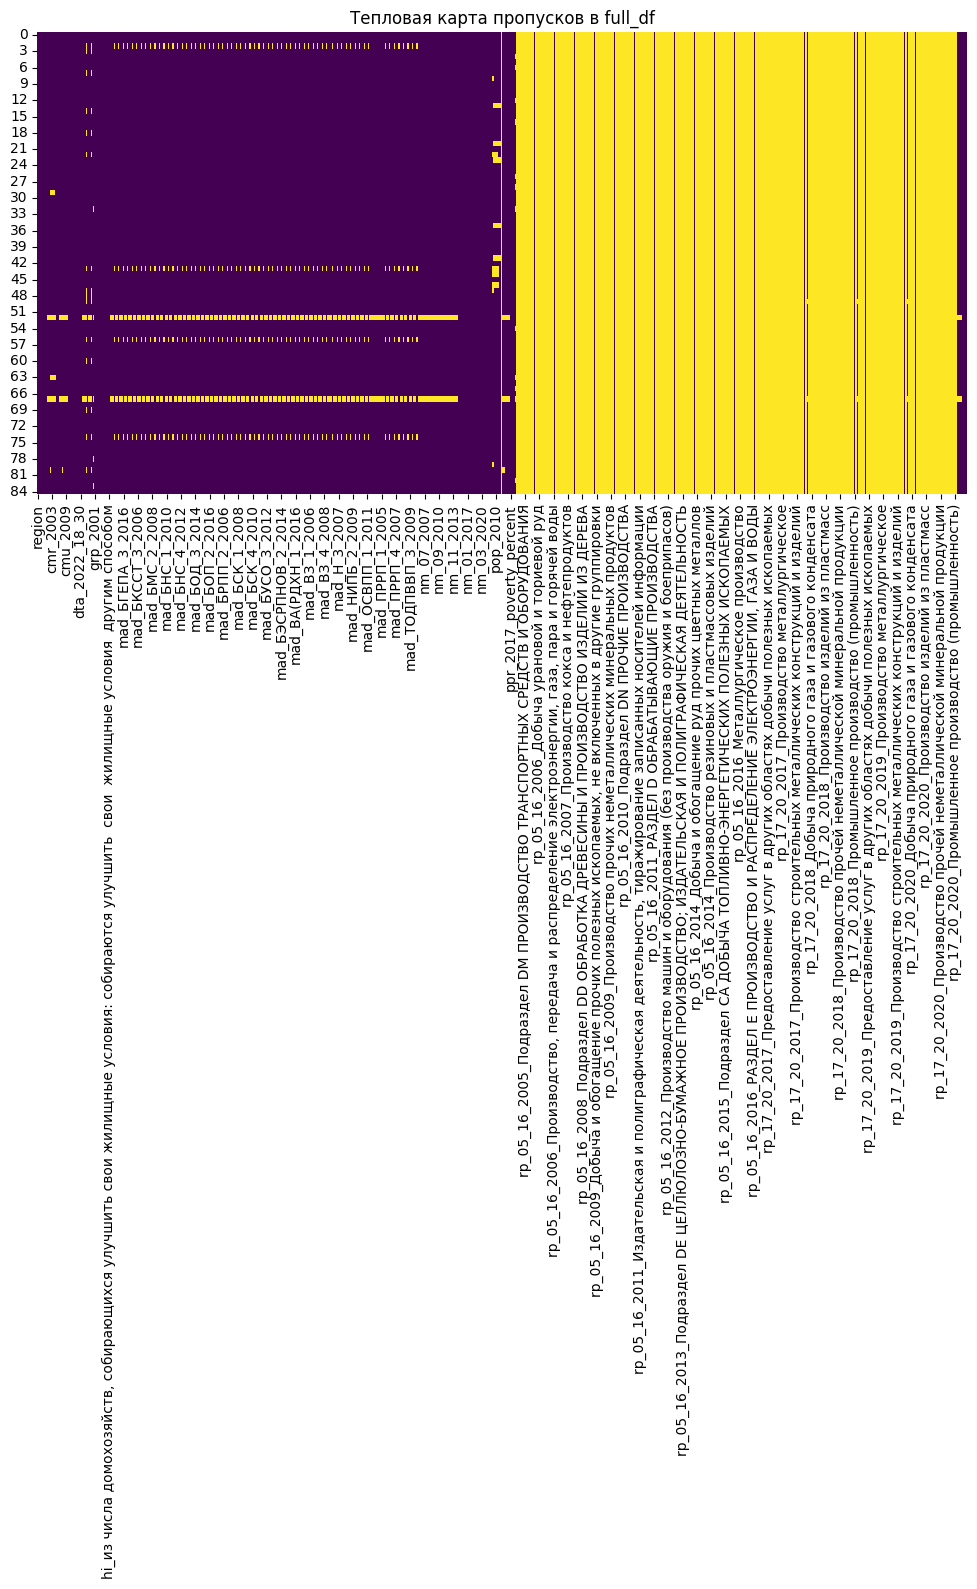

In [30]:
# Строим тепловую карту пропусков
plt.figure(figsize=(12, 6))
sns.heatmap(full_df.isnull(), cbar=False, cmap="viridis")
plt.title("Тепловая карта пропусков в full_df")
plt.show()

## 1.4. Поиск пропусков

> Согласно тепловой карте большая часть всех пропусков в датасетах **[clean_norm_rp_05_16, clean_norm_rp_17_20]**

*Это связано с производимыми в регионах товарами, потому что в каждом регионе свой вид производства*

*В данных таблицах все пропуски заменим на 0* ---> по итогу поличим нулевое производство в тех регионах где оно отутствует

In [31]:
clean_datasets['clean_norm_rp_05_16'] = clean_norm_rp_05_16.fillna(0)
clean_datasets['clean_norm_rp_17_20'] = clean_norm_rp_17_20.fillna(0)

> Замена выполнена, повторно соединим таблицы, посмотрим на процент оставшихся пропусков

In [32]:
full_df = merge_clean_datasets(clean_datasets)

C:\Users\User\AppData\Local\Temp\ipykernel_29528\453175547.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp = temp.groupby("region", as_index=False).first()


In [33]:
# Поиск строк, где процент пропусков преввышает 30%

row_nan_percent = full_df.isna().mean(axis=1) * 100
full_df[row_nan_percent > 30]

,region,pcci_2015,pcci_2016,pcci_2017,pcci_2018,pcci_2019,pcci_2020,ri_2015,ri_2016,ri_2017,...,rtpc_2018,rtpc_2019,rtpc_2020,rtpc_2021,wes_2015,wes_2016,wes_2017,wes_2018,wes_2019,wes_2020
52,республика_крым,15664.0,17825.0,19818.0,21524.0,22364.0,22950.0,NaN,102.1,106.4,...,133940,143660,148071,176044,12.6,10.2,13.6,13.5,13.0,15.5
67,севастополь,17774.0,26239.0,28130.0,28834.0,30261.0,29957.0,NaN,139.3,104.1,...,149255,154734,141383,187776,12.2,10.5,13.3,14.1,13.2,13.3


> Для более подробного анализа выполним функцию find_nantypes, которая ищет стркои с пропусками в датасетах и выводит их на экран

In [34]:
def find_nantypes(datasets: dict) -> dict:
    nantypes = {}
    for name, df in datasets.items():
        if df.isna().any().any():   # есть ли хоть один NaN
            nantypes[name] = df

    print(f'Общее количество датасетов с пропусками: {len(nantypes)}')
    print(f'Датасеты: {list(nantypes.keys())}')

    for name, df in nantypes.items():
        # ищем строки с NaN
        rows_with_null = df[df.isnull().any(axis=1)]
        if not rows_with_null.empty:
            print(f"\n{name}: найдено {len(rows_with_null)} строк с пропусками")
            display(rows_with_null)
        else:
            print(f"\n{name}: пропусков нет")

    return nantypes

nantypes = find_nantypes(clean_datasets)   

Общее количество датасетов с пропусками: 12
Датасеты: ['clean_norm_ri', 'clean_norm_cmr', 'clean_norm_cmu', 'clean_norm_alco_05_16', 'clean_norm_drugs_05_16', 'clean_norm_grp', 'clean_norm_mad', 'clean_norm_nm', 'clean_norm_pop', 'clean_norm_ppr', 'clean_norm_ps', 'clean_norm_rtpc']

clean_norm_ri: найдено 2 строк с пропусками


,region,2015,2016,2017,2018,2019,2020
52,республика_крым,NaN,102.1,106.4,105.9,99.0,99.5
67,севастополь,NaN,139.3,104.1,101.4,101.2,102.9



clean_norm_cmr: найдено 6 строк с пропусками


,region,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
29,москва,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,3.0,9.0,11.0,6.0,11.0,13.0,14.0,5.0,10.0,9.0
52,республика_крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,88.0,63.0,63.0,43.0,53.0,54.0,51.0
63,санкт_петербург,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67,севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,2.0,1.0,1.0,0.0,0.0,0.0
78,ханты_мансийский_автономный_округ_югра,44.0,44.0,40.0,46.0,25.0,47.0,31.0,34.0,33.0,...,15.0,9.0,10.0,10.0,8.0,15.0,5.0,4.0,5.0,NaN
80,чеченская_республика,662.0,660.0,510.0,0.0,0.0,0.0,0.0,NaN,NaN,...,439.0,269.0,319.0,244.0,190.0,171.0,137.0,99.0,72.0,81.0



clean_norm_cmu: найдено 4 строк с пропусками


,region,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
52,республика_крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,62.0,58.0,49.0,37.0,36.0,48.0,46.0
67,севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.0,24.0,19.0,12.0,15.0,15.0,21.0
78,ханты_мансийский_автономный_округ_югра,331.0,315.0,279.0,311.0,244.0,280.0,195.0,167.0,162.0,...,109.0,141.0,113.0,124.0,97.0,93.0,60.0,83.0,70.0,NaN
80,чеченская_республика,263.0,326.0,393.0,0.0,0.0,0.0,0.0,NaN,NaN,...,322.0,301.0,174.0,141.0,114.0,102.0,72.0,68.0,109.0,116.0



clean_norm_alco_05_16: найдено 15 строк с пропусками


,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
20,архангельская_область,120.1,115.2,102.5,89.8,96.5,99.5,84.4,73.2,77.6,NaN,NaN,NaN
29,республика_адыгея,120.6,126.7,102.0,132.8,132.7,129.1,116.4,110.5,82.8,NaN,NaN,NaN
30,республика_калмыкия,98.9,92.7,90.8,111.3,117.1,96.1,70.3,60.3,52.8,NaN,NaN,NaN
31,краснодарский_край,111.6,99.1,105.1,96.7,90.3,78.9,67.2,52.0,45.6,NaN,NaN,NaN
32,астраханская_область,137.1,166.0,130.3,116.1,134.5,113.4,91.7,84.7,61.8,NaN,NaN,NaN
33,волгоградская_область,156.6,137.9,113.6,116.0,102.6,93.6,88.0,73.6,67.9,NaN,NaN,NaN
34,ростовская_область,102.5,100.9,82.7,86.6,79.8,72.7,63.5,56.2,50.3,NaN,NaN,NaN
35,республика_дагестан,36.8,37.7,32.7,31.9,31.3,31.8,23.9,28.8,23.1,NaN,NaN,NaN
36,республика_ингушетия,2.7,2.9,0.0,0.6,0.4,0.4,0.5,0.7,1.6,NaN,NaN,NaN
37,кабардино_балкарская_республика,90.2,85.8,80.7,81.6,88.8,82.9,62.1,63.9,81.0,NaN,NaN,NaN



clean_norm_drugs_05_16: найдено 15 строк с пропусками


,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
20,архангельская_область,1.5,1.4,1.4,2.6,3.4,4.6,6.4,4.0,4.0,NaN,NaN,NaN
29,республика_адыгея,45.8,50.2,50.2,37.3,16.9,14.0,15.2,12.4,5.9,NaN,NaN,NaN
30,республика_калмыкия,19.7,29.2,29.2,10.9,6.0,5.3,3.8,4.5,0.4,NaN,NaN,NaN
31,краснодарский_край,39.9,43.3,43.3,27.8,15.3,10.5,9.8,6.0,4.3,NaN,NaN,NaN
32,астраханская_область,10.7,12.9,12.9,6.8,8.1,9.8,7.5,5.1,2.3,NaN,NaN,NaN
33,волгоградская_область,11.0,17.9,17.9,13.9,19.8,21.9,16.1,15.0,6.0,NaN,NaN,NaN
34,ростовская_область,7.1,8.4,8.4,7.4,9.8,10.8,17.5,12.8,12.3,NaN,NaN,NaN
35,республика_дагестан,15.3,20.0,20.0,17.1,12.9,16.8,16.7,14.5,14.6,NaN,NaN,NaN
36,республика_ингушетия,6.4,6.7,6.7,4.8,4.1,0.6,1.2,0.7,1.4,NaN,NaN,NaN
37,кабардино_балкарская_республика,31.9,37.6,37.6,21.1,16.7,17.7,17.7,17.2,12.8,NaN,NaN,NaN



clean_norm_grp: найдено 5 строк с пропусками


,region,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
32,ненецкий_автономный_округ,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3913588.7,3685897.1,4035943.2,4329031.1,5210143.9,5964557.0,6045235.6,7296374.4,7530484.7,5206287.1
52,республика_крым,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,100526.4,139873.3,189916.6,201251.2,228692.9,245411.7,270363.8
67,севастополь,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,78009.3,119384.5,211366.0,234060.8,276550.7,306891.7,295304.9
78,ханты_мансийский_автономный_округ_югра,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1575300.0,1719109.2,1715722.4,1782617.7,1947653.2,1912836.6,2155227.7,2715827.8,2733622.7,1994630.3
83,ямало_ненецкий_автономный_округ,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1820301.3,2209803.4,2544898.0,3025745.6,3336453.4,3790547.2,4571566.9,5650999.3,5710467.4,5072483.6



clean_norm_mad: найдено 6 строк с пропусками


,region,БГЕПА_1_2005,БГЕПА_1_2006,БГЕПА_1_2007,БГЕПА_1_2008,БГЕПА_1_2009,БГЕПА_1_2010,БГЕПА_1_2011,БГЕПА_1_2012,БГЕПА_1_2013,...,ТОДПВВП_4_2007,ТОДПВВП_4_2008,ТОДПВВП_4_2009,ТОДПВВП_4_2010,ТОДПВВП_4_2011,ТОДПВВП_4_2012,ТОДПВВП_4_2013,ТОДПВВП_4_2014,ТОДПВВП_4_2015,ТОДПВВП_4_2016
2,архангельская_область,6389.1,6652.3,7234.2,8031.0,9822.2,10795.8,10534.7,9755.5,9693.2,...,11566.7,11357.4,11132.4,11130.7,10874.8,11868.4,12297.9,NaN,NaN,NaN
43,республика_адыгея,2280.8,2108.8,2428.3,2931.3,4403.2,3983.9,4382.6,4544.0,4008.7,...,7398.7,7850.4,7549.7,7934.9,8279.4,8450.2,8076.2,NaN,NaN,NaN
52,республика_крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4223.4,5716.2,5563.5
56,республика_северная_осетия_алания,4420.7,4066.1,4297.1,4602.0,5499.9,6797.9,6987.8,5724.8,5181.8,...,6898.9,6694.9,6961.5,7279.8,6949.2,6723.3,6941.7,NaN,NaN,NaN
67,севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4409.6,2239.1,2140.1
74,тюменская_область,7088.3,6487.4,7089.2,6926.0,6568.9,6521.1,6077.6,6161.6,3891.9,...,8920.7,8816.6,8627.2,8594.3,8909.5,8488.3,5133.8,NaN,NaN,NaN



clean_norm_nm: найдено 2 строк с пропусками


,region,01_2006,02_2006,03_2006,04_2006,05_2006,06_2006,07_2006,08_2006,09_2006,...,08_2021,09_2021,10_2021,11_2021,12_2021,01_2022,02_2022,03_2022,04_2022,05_2022
52,республика_крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1650,1624,1542,1584,1520,1248,1302,1505,1258,1194
67,севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,398,387,353,343,398,328,298,413,277,283



clean_norm_pop: найдено 12 строк с пропусками


,region,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
8,вологодская_область,NaN,NaN,NaN,NaN,NaN,1273668.0,1257312.0,1239924.0,1224813.0,...,1159506.0,1148760.0,1139950.0,1130240.0,1121813.0,1111031.0,1100290.0,1092424.0,1082662.0,1069782.0
13,иркутская_область,19014.0,18469.0,18012.0,17751.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,кировская_область,139790.0,138877.0,137648.0,136608.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,краснодарский_край,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1895915.0,1907106.0,1912168.0,1913731.0,1911818.0,1912622.0,1901578.0,1896393.0
23,красноярский_край,71325.0,71307.0,71162.0,71777.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,новосибирская_область,134461.0,134694.0,134735.0,135210.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,приморский_край,27480.0,26645.0,25831.0,25685.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,республика_адыгея,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,16428458.0,16441852.0,16454550.0,16466084.0,16482488.0,16434898.0
44,республика_алтай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,17173335.0,17118387.0,17003927.0,16889404.0
46,республика_бурятия,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8188623.0,8169203.0,8124053.0,8091244.0



clean_norm_ppr: найдено 85 строк с пропусками


,region,1992_poverty_percent,1993_poverty_percent,1994_poverty_percent,1995_poverty_percent,1996_poverty_percent,1997_poverty_percent,1998_poverty_percent,1999_poverty_percent,2000_poverty_percent,...,2011_poverty_percent,2012_poverty_percent,2013_poverty_percent,2014_poverty_percent,2015_poverty_percent,2016_poverty_percent,2017_poverty_percent,2018_poverty_percent,2019_poverty_percent,2020_poverty_percent
0,алтайский_край,NaN,NaN,NaN,33.7,46.8,45.7,52.9,53.8,53.9,...,22.6,20.6,17.6,17.1,18.0,17.8,17.5,17.4,17.6,17.5
1,амурская_область,NaN,NaN,NaN,36.1,28.2,26.3,31.2,38.0,47.7,...,20.4,16.0,16.2,14.8,15.2,17.0,16.7,15.6,15.7,15.2
2,архангельская_область,NaN,NaN,NaN,26.2,26.8,23.9,31.6,42.6,33.5,...,14.4,13.2,14.6,14.8,16.5,15.2,14.3,13.5,13.6,12.8
3,астраханская_область,NaN,NaN,NaN,32.3,30.7,25.0,30.4,36.0,33.4,...,14.2,12.5,11.8,12.0,14.2,16.1,15.5,15.1,15.5,15.6
4,белгородская_область,NaN,NaN,NaN,19.9,17.6,18.9,20.1,24.2,33.6,...,8.6,6.5,7.6,7.7,8.5,8.1,7.8,7.5,7.8,7.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,чеченская_республика,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,21.7,17.8,14.2,16.0,17.3,20.7,20.5,20.7,20.4
81,чувашская_республика,NaN,NaN,NaN,27.0,27.0,28.4,43.0,57.2,51.3,...,19.3,16.0,16.5,16.4,17.9,18.8,18.4,17.8,17.4,16.8
82,чукотский_автономный_округ,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,50.1,...,9.0,7.7,7.5,7.6,8.6,8.6,8.5,8.8,8.5,8.0
83,ямало_ненецкий_автономный_округ,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,11.1,...,7.4,6.4,6.4,6.7,7.5,7.1,6.1,5.8,5.5,4.8



clean_norm_ps: найдено 12 строк с пропусками


,region,2017_proc_child,2017_proc_pension,2017_proc_work,2018_proc_child,2018_proc_pension,2018_proc_work,2019_proc_child,2019_proc_pension,2019_proc_work,2020_proc_child,2020_proc_pension,2020_proc_work
4,белгородская_область,43.4,11.8,44.8,44.8,12.9,42.3,0.0,0.0,0.0,NaN,NaN,NaN
6,владимирская_область,34.8,8.6,56.6,48.9,8.3,42.8,34.8,4.8,60.4,NaN,NaN,NaN
12,ивановская_область,33.2,10.9,55.9,31.2,9.5,59.3,47.5,5.0,47.5,NaN,NaN,NaN
16,калужская_область,41.5,8.0,50.6,40.8,5.5,53.7,31.1,18.4,50.4,NaN,NaN,NaN
26,ленинградская_область,31.5,6.4,62.1,19.0,17.0,64.1,0.0,0.0,0.0,NaN,NaN,NaN
28,магаданская_область,32.2,14.8,53.0,30.7,11.5,57.8,45.8,0.0,54.2,NaN,NaN,NaN
32,ненецкий_автономный_округ,50.5,1.0,48.4,50.5,5.5,44.0,45.6,2.0,52.4,NaN,NaN,NaN
54,республика_мордовия,35.3,6.2,58.6,38.0,4.2,57.8,26.8,12.1,61.2,NaN,NaN,NaN
63,санкт_петербург,26.6,0.0,73.4,25.7,9.8,64.6,0.0,0.0,0.0,NaN,NaN,NaN
65,сахалинская_область,36.4,6.4,57.1,32.9,4.3,62.8,44.9,12.1,43.0,NaN,NaN,NaN



clean_norm_rtpc: найдено 2 строк с пропусками


,region,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
52,республика_крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,79010,112916,115133,120177,133940,143660,148071,176044
67,севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,90459,94360,145575,146264,149255,154734,141383,187776


> Помимо датасетов **['clean_norm_rp_05_16', 'clean_norm_rp_17_20']** имеются пропуски ещё в 12 таблицах

**В новых субъектах РФ таких как таких как *г.Севастополь и Республика_Крым* количество пропусков более 30%**

>- удалим строки *г.Севастополь и Республика_Крым*

>- В датасете **[clean_norm_pop] (численность населения)** помимо пропусков присутствуют аномальные значения в регионах (***иркутская_область, кировская_область, красноярский_край, 	новосибирская_область, приморский_край)*** - численность населения менее 500 тыс. чел. Данный датасет проработаем отдельно

>- для остальных регионов выполним замену пропусков(для крайних ---> предыдущее значения, для центральных ---> интерполяция)


In [35]:
def impute_timeseries_nantypes(
    nantypes: dict,                       # словарь только с датасетами, где есть NaN
    id_col: str = "region",
    ignore: set = {"clean_norm_rp_17_20", "clean_norm_rp_05_16", "clean_norm_pop", "clean_norm_ps"},
    drop_regions: list = ["севастополь", "республика_крым"],
    update_source: dict | None = None,    # если передать исходный словарь (например clean_datasets),
                                          # он будет обновлён только изменёнными таблицами
    set_globals: bool = False             # при True создаст переменные в глобальной области (как раньше)
) -> dict:
    imputed = {}

    for name, df in nantypes.items():
        cleaned = df.copy()

        if name not in ignore:
            # числовые (годовые) колонки
            ycols = [
                c for c in cleaned.columns
                if c != id_col and (str(c).isdigit() or pd.api.types.is_numeric_dtype(cleaned[c]))
            ]

            if ycols and cleaned[ycols].isna().any().any():   # имpute только если реально есть NaN
                block = cleaned[ycols].astype(float)
                block = block.T.interpolate("linear", limit_area="inside").T
                block = block.ffill(axis=1).bfill(axis=1)
                cleaned[ycols] = block

        # убрать указанные регионы
        if id_col in cleaned.columns:
            cleaned = cleaned[~cleaned[id_col].isin(drop_regions)].reset_index(drop=True)

        imputed[name] = cleaned
        if set_globals:
            globals()[name] = cleaned

    # опционально — обновить внешний словарь всех датасетов только теми, что исправили
    if isinstance(update_source, dict):
        update_source.update(imputed)

    return imputed

In [36]:
# Заменяем Nan инетрполяцией проме pop и ps
imputed_nans = impute_timeseries_nantypes(nantypes)

# Обновление словаря датасетов
clean_datasets.update(imputed_nans)

# Повторная проверка пропусков
nantypes = find_nantypes(clean_datasets) 

Общее количество датасетов с пропусками: 2
Датасеты: ['clean_norm_pop', 'clean_norm_ps']

clean_norm_pop: найдено 12 строк с пропусками


,region,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
8,вологодская_область,NaN,NaN,NaN,NaN,NaN,1273668.0,1257312.0,1239924.0,1224813.0,...,1159506.0,1148760.0,1139950.0,1130240.0,1121813.0,1111031.0,1100290.0,1092424.0,1082662.0,1069782.0
13,иркутская_область,19014.0,18469.0,18012.0,17751.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,кировская_область,139790.0,138877.0,137648.0,136608.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,краснодарский_край,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1895915.0,1907106.0,1912168.0,1913731.0,1911818.0,1912622.0,1901578.0,1896393.0
23,красноярский_край,71325.0,71307.0,71162.0,71777.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,новосибирская_область,134461.0,134694.0,134735.0,135210.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,приморский_край,27480.0,26645.0,25831.0,25685.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,республика_адыгея,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,16428458.0,16441852.0,16454550.0,16466084.0,16482488.0,16434898.0
44,республика_алтай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,17173335.0,17118387.0,17003927.0,16889404.0
46,республика_бурятия,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8188623.0,8169203.0,8124053.0,8091244.0



clean_norm_ps: найдено 11 строк с пропусками


,region,2017_proc_child,2017_proc_pension,2017_proc_work,2018_proc_child,2018_proc_pension,2018_proc_work,2019_proc_child,2019_proc_pension,2019_proc_work,2020_proc_child,2020_proc_pension,2020_proc_work
4,белгородская_область,43.4,11.8,44.8,44.8,12.9,42.3,0.0,0.0,0.0,NaN,NaN,NaN
6,владимирская_область,34.8,8.6,56.6,48.9,8.3,42.8,34.8,4.8,60.4,NaN,NaN,NaN
12,ивановская_область,33.2,10.9,55.9,31.2,9.5,59.3,47.5,5.0,47.5,NaN,NaN,NaN
16,калужская_область,41.5,8.0,50.6,40.8,5.5,53.7,31.1,18.4,50.4,NaN,NaN,NaN
26,ленинградская_область,31.5,6.4,62.1,19.0,17.0,64.1,0.0,0.0,0.0,NaN,NaN,NaN
28,магаданская_область,32.2,14.8,53.0,30.7,11.5,57.8,45.8,0.0,54.2,NaN,NaN,NaN
32,ненецкий_автономный_округ,50.5,1.0,48.4,50.5,5.5,44.0,45.6,2.0,52.4,NaN,NaN,NaN
53,республика_мордовия,35.3,6.2,58.6,38.0,4.2,57.8,26.8,12.1,61.2,NaN,NaN,NaN
62,санкт_петербург,26.6,0.0,73.4,25.7,9.8,64.6,0.0,0.0,0.0,NaN,NaN,NaN
64,сахалинская_область,36.4,6.4,57.1,32.9,4.3,62.8,44.9,12.1,43.0,NaN,NaN,NaN


In [37]:
# Повторно соединяем датасеты
full_df = merge_clean_datasets(clean_datasets)

C:\Users\User\AppData\Local\Temp\ipykernel_29528\453175547.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp = temp.groupby("region", as_index=False).first()


In [38]:
# Удаляем ["республика_крым", "севастополь"]

full_df = full_df[~full_df["region"].isin(["республика_крым", "севастополь"])].reset_index(drop=True)

### 1.4.2. Очистка и замена пропусков выполнена успешно ---> имеем полный датасет из 83 строк и 2466 колонн

> Выпололним поиск и удаление колонн с нулевыми значениями (удалим все колонны где количество нулевых значений > 40%)

*Для колонн с префиксом **rp - [regional_production]** расчет процента пропусков пропустим, так как у нас много категорий производства, и если регион не производит ту или иную продукцию значение 0 оправдано. В данных колоннах удаляем только те категории, где все значения в троках равны 0*



> Посмотрим долью удалённых колонн (по префиксам)

In [39]:
# Функция поиска и удаления 
def to_float_and_drop_zero(df,
                           id_col:"region",
                           threshold: None):
    out = df.copy()

    # 0) Поддержка threshold и как 0.4, и как 40
    thr = threshold / 100 if threshold > 1 else threshold

    # 1) Приведение к float
    value_cols = [c for c in out.columns if c != id_col]
    out[value_cols] = out[value_cols].apply(pd.to_numeric, errors="coerce").astype(float)

    # 2) Полностью нулевые столбцы
    num = out[value_cols]
    full_zero_cols = num.columns[(num.fillna(0).sum() == 0)].tolist()

    # 3) Столбцы с долей нулей > threshold (без 'rp*')
    zero_share = {}
    sparse_cols = []
    n = len(out)
    check_cols = [c for c in out.columns if c != id_col and not str(c).startswith("rp")]
    if n > 0:
        for col in check_cols:
            zeros = (out[col] == 0).sum()
            share = zeros / n
            if share > thr:
                zero_share[col] = round(share * 100, 2)
                sparse_cols.append(col)

    # 4) Объединяем оба списка
    zero_cols = sorted(set(full_zero_cols + sparse_cols))

    # 5) Удаляем эти колонки
    out = out.drop(columns=zero_cols)

    return out, zero_cols, zero_share

In [40]:
full_df_clean, dropped_zero_cols, zero_share = to_float_and_drop_zero(full_df, "region", 0.4)

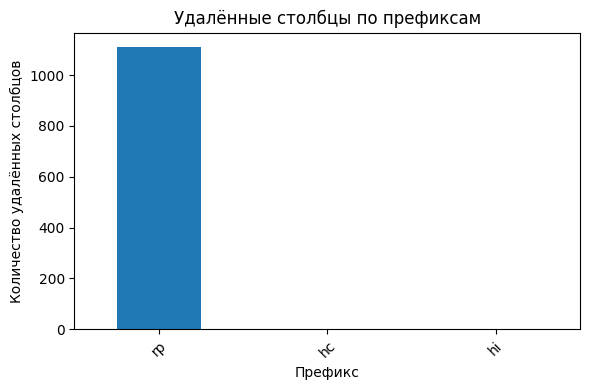

In [41]:
# считаем количество удалённых по префиксу
prefix_counts_drop = pd.Series([c.split("_")[0] for c in dropped_zero_cols]).value_counts()

# строим диаграмму
plt.figure(figsize=(6,4))
prefix_counts_drop.plot(kind="bar")
plt.title("Удалённые столбцы по префиксам")
plt.xlabel("Префикс")
plt.ylabel("Количество удалённых столбцов")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

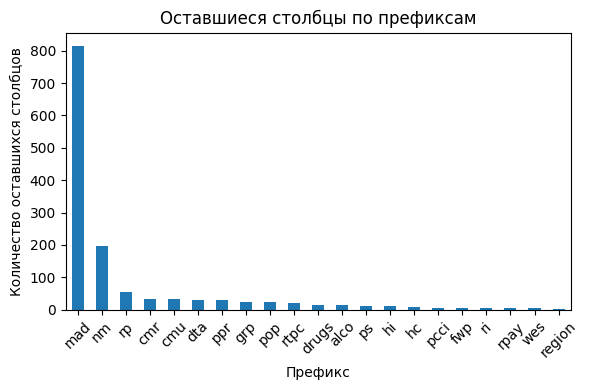

In [42]:
# считаем количество оставшихся по префиксу
prefix_counts = pd.Series([c.split("_")[0] for c in full_df_clean]).value_counts()

# строим диаграмму
plt.figure(figsize=(6,4))
prefix_counts.plot(kind="bar")
plt.title("Оставшиеся столбцы по префиксам")
plt.xlabel("Префикс")
plt.ylabel("Количество оставшихся столбцов")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.4.1. Корректировка колонок population

> В колонках pop_[year] присутствуют аномальные занчения, например в строках (***иркутская_область, кировская_область, красноярский_край, 	новосибирская_область, приморский_край)*** аномально низкие значения, а в строке ***белгородская область*** аномально высокие значения.

Для общей проверки посчитаем сумму населения по строкам, по данным росстата **оринетировочная численность населения за 2022 год - 147 млн. чел.**

In [43]:
full_df_clean['pop_2022'].sum()

np.float64(253370478.0)

> Общая численность населения аномально высокая на **100 млн чел. выше статистики**

Для анализа подгрузим таблицу численности населения по субъектам РФ за 2023 год с сайта Росстата:
http://ssl.rosstat.gov.ru/storage/mediabank/BUL_MO_2023.xlsx

Выполним преобразование датасета по аналогии с [1]


In [44]:
pop_df = pd.read_excel('data/BUL_MO_2023.xlsx', sheet_name=3, skiprows=4)
pop_df = pop_df.rename(columns={'Unnamed: 0':'region'})
pop_df = pop_df.rename(columns={'Все население':'count'})
pop_df = pop_df[['region', 'count']]
pop_dict = {'pop_df' : pop_df}

# 2) нормализуем датасеты
pop_dict_2023 = normalize_datasets(pop_dict, "region")

# 3) обрезаем «хвосты» после канона
pop_dict_2023 = apply_strip_suffix(pop_dict_2023, "region", regions)

# 4) применяем алиасы
pop_dict_2023 = apply_aliases(pop_dict_2023, "region", ALIASES)

# 5) финальная проверка (с игнором по набором)
missing = find_missing_refs_full(pop_dict_2023, "region", regions, IGNORE_BY_DATASET)

# 6) вывод результата
for name, miss in missing.items():
    print(f"\n{name}:")
    for m in miss:
        print(" ", m)

# Все совпадения найдены

clean_pop_2023, regions = build_clean_datasets(pop_dict_2023, regions)

pop_2023 = clean_pop_2023['clean_norm_pop_df']

def pop23_keep_filled(df, col="region"):
    df = df.rename(columns={'count' : 'pop_2023'})
    df = df[~df[col].isin(['республика_крым', 'севастополь'])]
    filled = df.notna().sum(axis=1)  # сколько непустых в строке
    idx = filled.groupby(df[col]).idxmax() # индексы самых «полных» строк
    return df.loc[idx].reset_index(drop=True)

before = len(pop_2023)
pop_2023 = pop23_keep_filled(pop_2023, "region")
after = len(pop_2023)
print(f"Было {before} → стало {after} строк")

Было 87 → стало 83 строк


In [45]:
# Добавим данные в полный датасет

full_df_clean = full_df_clean.merge(pop_2023, on = 'region', how = 'left')

# Суммарное количетсво населения по субъектам РФ
full_df_clean['pop_2023'].sum()

np.int64(146256469)

> **Скачанные данные актуальны - общая сумма населения соответствует статиситческим данным**

In [46]:
# Фильтруем датасет по колонкам pop_YYYY
cols = ['region'] + full_df_clean.filter(like = 'pop').columns.tolist()
pop_df = full_df_clean[cols]

In [47]:
# Вичислим разницу по численности населеиня по регионам за 2022 и 2023 года
pop_df['coff'] = pop_df['pop_2023']/pop_df['pop_2022']

C:\Users\User\AppData\Local\Temp\ipykernel_29528\4129826825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_df['coff'] = pop_df['pop_2023']/pop_df['pop_2022']


C:\Users\User\AppData\Local\Temp\ipykernel_29528\1073358555.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


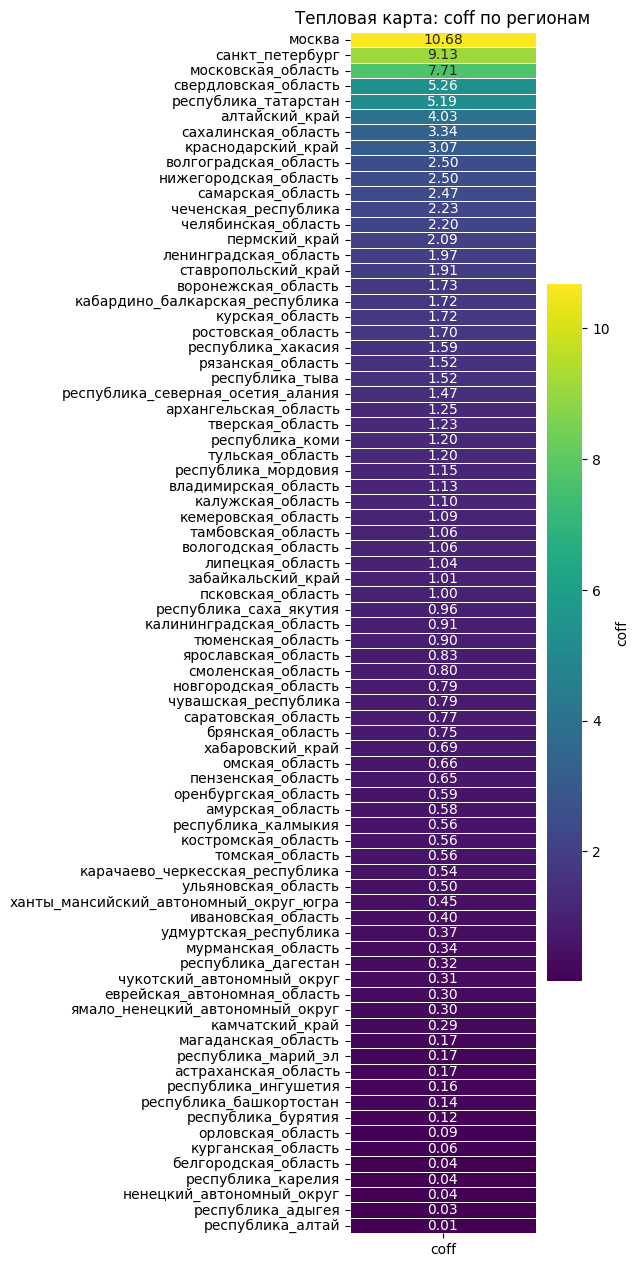

In [48]:
tmp = (pop_df[['region', 'coff']]
       .dropna(subset=['coff'])
       .groupby('region', as_index=False)['coff'].mean())

# отсортируем, чтобы «градиент» читался
tmp = tmp.sort_values('coff', ascending=False)

plt.figure(figsize=(3, max(6, len(tmp)*0.2)))  # высота подстраивается под число регионов
sns.heatmap(tmp.set_index('region')[['coff']],  # делаем 2D-матрицу: индекс=region, 1 колонка coff
            cmap='viridis', cbar_kws={'label': 'coff'},
            linewidths=.5, linecolor='white',
            annot=True, fmt='.2f')  # хочешь без цифр — убери annot
plt.title("Тепловая карта: coff по регионам")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

> Разброс коэффицентов высокий, т.е. по сревнению с 2022 годом в Москве выросло население в 10 раз, а в резпублике алтай уменьшилось в 100 раз


***Считаем, что стасистика за 2023 год - эталонная, для преобразования остальных колонок выполним функцию интерполяции***:
- найдём коэффициенты роста/спада населения по годам и регионам;
- распределим статистику за 2023 год по колонкам;
- в крайних колонках [pop_1999, pop_2022] и в строках с пропусками NaN поставим коэффицент 1

In [49]:
def interpolate_population(df, year_start=1999, year_end=2023, prefix="pop"):
    # приводим названия колонок к строкам
    df = df.copy()
    df.columns = df.columns.map(str)

    cols = [c for c in df.columns if c.startswith(prefix)]
    years = sorted([int(c.split("_")[1]) for c in cols])

    # Словарь коэффициентов
    k = {}
    for y in years[:-1]:
        col_now = f"{prefix}_{y}"
        col_next = f"{prefix}_{y+1}"
        if col_now in df and col_next in df:
            ratio = df[col_now] / df[col_next]
            ratio = ratio.replace([np.inf, -np.inf], np.nan).fillna(1.0)
            k[y] = ratio
        else:
            k[y] = pd.Series(1.0, index=df.index)

    # В крайних годах коэффициенты = 1
    k[year_start] = pd.Series(1.0, index=df.index)
    k[year_end-1] = pd.Series(1.0, index=df.index)

    # Строим новые значения от pop_2023
    out = df.copy()
    out[f"{prefix}_{year_end}"] = df[f"{prefix}_{year_end}"]
    for y in range(year_end-1, year_start-1, -1):
        out[f"{prefix}_{y}"] = (out[f"{prefix}_{y+1}"] * k.get(y, 1.0)).round().astype("Int64")

    # Коэффициенты в отдельный датафрейм
    k_df = pd.DataFrame({f"k_{y}": k[y].astype(float).round(6) for y in range(year_start, year_end)})

    return out, k_df

In [50]:
# Вызов функции
new_pop, k_table = interpolate_population(pop_df)

In [51]:
new_pop.head()

,region,pop_1999,pop_2000,pop_2001,pop_2002,pop_2003,pop_2004,pop_2005,pop_2006,pop_2007,...,pop_2015,pop_2016,pop_2017,pop_2018,pop_2019,pop_2020,pop_2021,pop_2022,pop_2023,coff
0,алтайский_край,2248490,2248490,2236108,2216256,2198949,2183687,2169808,2153074,2142249,...,2161029,2165002,2168580,2167955,2162526,2154843,2145865,2130950,2130950,4.033308
1,амурская_область,858014,858014,849883,841890,834942,824453,813145,801188,791661,...,779091,776906,776174,773268,769293,765899,757449,756198,756198,0.582148
2,архангельская_область,1324106,1324106,1305340,1288773,1271745,1251489,1230252,1205296,1182596,...,1081972,1072468,1064611,1052494,1039179,1026960,1018345,1005687,1005687,1.251669
3,астраханская_область,857979,857979,857870,857673,855707,854879,855547,856942,859559,...,911440,921547,931097,936525,944015,948566,949984,950557,950557,0.167134
4,белгородская_область,1480570,1480570,1478534,1474404,1469693,1470400,1473460,1475975,1478855,...,1508604,1514524,1518601,1522545,1525126,1527275,1520203,1514527,1514527,0.038730


In [52]:
# Таблица коэффициентов роста/спада населения
k_table.head()

,k_1999,k_2000,k_2001,k_2002,k_2003,k_2004,k_2005,k_2006,k_2007,k_2008,...,k_2013,k_2014,k_2015,k_2016,k_2017,k_2018,k_2019,k_2020,k_2021,k_2022
0,1.0,1.005537,1.008957,1.007871,1.006989,1.006396,1.007772,1.005053,0.999686,0.998934,...,0.998027,0.996795,0.998165,0.998350,1.000288,1.002510,1.003566,1.004184,1.006999,1.0
1,1.0,1.009568,1.009495,1.008321,1.012723,1.013906,1.014925,1.012035,1.003724,1.002757,...,1.001620,1.001201,1.002812,1.000944,1.003758,1.005168,1.004431,1.011156,1.001654,1.0
2,1.0,1.014377,1.012855,1.013389,1.016185,1.017262,1.020705,1.019195,1.010642,1.013603,...,1.009841,1.008830,1.008862,1.007380,1.011513,1.012813,1.011898,1.008460,1.012587,1.0
3,1.0,1.000127,1.000230,1.002297,1.000968,0.999219,0.998372,0.996955,0.994628,0.995427,...,0.986290,0.991004,0.989032,0.989743,0.994204,0.992066,0.995203,0.998507,0.999397,1.0
4,1.0,1.001377,1.002801,1.003206,0.999519,0.997924,0.998296,0.998053,0.999301,0.998610,...,0.996369,0.996621,0.996091,0.997315,0.997410,0.998308,0.998593,1.004652,1.003748,1.0


In [53]:
# Обновление исходного датасета
full_df_clean = full_df_clean.drop(cols[1:], axis=1)
full_df_clean = full_df_clean.merge(new_pop, on = 'region', how = 'left')

In [54]:
# Удаляем эталон, коэффициенты
full_df_clean = full_df_clean.drop(['pop_2023', 'coff'], axis = 1)
full_df_clean.shape

(83, 1352)

### 1.4.3. Корректировка колонок ***[nm] - Ежемесячное количество новорожденных***

> Понизим размерность признаков nm, превратив ежемесечное количество в ежегодное

In [55]:
# берём все object-колонки, кроме 'region'
num_cols = full_df_clean.select_dtypes(include="object").columns.drop("region")

for col in num_cols:
    full_df_clean[col] = (
        full_df[col]
        .astype(str)
        .str.replace(r"\s+", "", regex=True)   # убираем пробелы
        .str.replace(",", ".", regex=False)    # запятая → точка
    )
    # переводим в число, "мусор" станет NaN
    full_df_clean[col] = pd.to_numeric(full_df_clean[col], errors="coerce")

In [56]:
# сгруппируем месяцы по годам
import warnings
warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)

year_groups = {}
for col in full_df_clean.columns:
    m = re.match(r"nm_\d{2}_(\d{4})", col)
    if m:
        year = m.group(1)
        year_groups.setdefault(year, []).append(col)

# создаём новые колонки nm_YYYY
for year, cols in year_groups.items():
    full_df_clean[f"nm_{year}"] = full_df_clean[cols].sum(axis=1)

# удаляем месячные признаки
full_df_clean = full_df_clean.drop(columns=[c for cols in year_groups.values() for c in cols])

In [57]:
cols = full_df_clean.filter(like='nm_').columns
full_df_clean[cols].head()

,nm_2006,nm_2007,nm_2008,nm_2009,nm_2010,nm_2011,nm_2012,nm_2013,nm_2014,nm_2015,nm_2016,nm_2017,nm_2018,nm_2019,nm_2020,nm_2021,nm_2022
0,23376.0,28209.0,19674.0,28067.0,25741.0,25191.0,30156.0,29892.0,26361.0,27475.0,26325.0,21215.0,23491.0,21117.0,19976.0,18992.0,7240.0
1,10405.0,9957.0,11233.0,9412.0,11473.0,11188.0,11733.0,10513.0,10189.0,10781.0,10377.0,9430.0,8889.0,7919.0,7853.0,7343.0,2816.0
2,13991.0,15088.0,15271.0,15461.0,15514.0,14894.0,15470.0,15295.0,15048.0,14670.0,14121.0,11387.0,10301.0,10253.0,9500.0,9040.0,3391.0
3,11403.0,13370.0,14200.0,14350.0,14355.0,13360.0,15304.0,15042.0,15216.0,14875.0,14270.0,12321.0,11800.0,11005.0,9901.0,10709.0,3764.0
4,14269.0,15666.0,16810.0,16911.0,16669.0,16894.0,17913.0,17883.0,17822.0,17864.0,17261.0,15113.0,14318.0,12204.0,11366.0,12223.0,4428.0


### 1.4.4. Корректировка колонок ppr и ps

- ***ppr - Процент людей, живущих за чертой бедности***
-  ***ps - Распределение малоимущего населения***

> Данные признаки играют важную роль в нашей задаче, поэтому выполним допю корректировку по замене нулей

In [58]:
# Замена нулей и NaN на среднее значения по колонке

cols = full_df_clean.filter(regex=r"(ppr|ps)_").columns
means = full_df_clean[cols].mean()
full_df_clean[cols] = full_df_clean[cols].where(full_df_clean[cols] > 0, pd.DataFrame([means], index=df.index))
full_df_clean[cols] = full_df_clean[cols].fillna(full_df_clean[cols].mean())

### 1.4.5 Удаление шумовых признаков (1990-2004 гг)

> Так как наша задача подразумевает поиск малообеспеченного населения по регионам на данный момент времени, избавимся от лишних статистических данных.

***В статистических данных за 1990-2004 годы:***
- присутствуют пропуски на несколько лет вперёд, которые сложно восстанвоить статистическими методами (интерполяция, среднее, медианое и тп.)

- Данные колонки никак не отражают текущую экономиескую ситуацию в сране и регионах


In [59]:
# регулярка ищет 4 цифры в конце имени колонки
def is_old_year(col):
    m = re.search(r"(\d{4})", str(col))
    if m:
        year = int(m.group(1))
        # Убираем статистику за 1990-2004 гг
        return 1990 <= year <= 2004
    return False

# оставляем только "хорошие" колонки
cols_to_drop = [c for c in full_df_clean.columns if is_old_year(c)]
full_df_clean= full_df_clean.drop(columns=cols_to_drop)

print(f"Удалено {len(cols_to_drop)} колонок")

Удалено 63 колонок


### 1.4.6. Повторная проверка на пропуски 

In [60]:
nan_cols = full_df_clean.columns[full_df_clean.isna().any()].tolist()
print(full_df_clean.isna().sum().sum())
full_df_clean[nan_cols]

132


,"hi_из числа домохозяйств, собирающихся улучшить свои жилищные условия: планируют вселиться в жилое помещение, строительство которого ведут (участвуют в долевом строительстве)","hi_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются подать документы для постановки на очередь (и/или ожидают прохождения очереди)","hi_из числа домохозяйств, собирающихся улучшить свои жилищные условия: рассчитывают на получение нового жилья в связи со сносом дома","hi_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются купить (построить) другое жилье","hi_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются снимать жилье","hi_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются улучшить свои жилищные условия другим способом"
0,3.1,5.0,0.8,31.5,3.9,56.2
1,16.6,5.5,1.8,32.6,7.1,35.1
2,15.7,3.4,6.3,32.7,4.6,37.3
3,7.5,8.1,9.6,36.3,0.9,36.2
4,11.2,1.6,1.6,29.5,0.0,56.9
...,...,...,...,...,...,...
78,13.0,2.9,0.0,12.8,0.3,71.0
79,8.3,6.0,0.9,34.8,0.0,50.6
80,NaN,NaN,NaN,NaN,NaN,NaN
81,9.0,17.3,11.0,20.0,4.9,36.9


> После всех совершенных манипуляций, у нас появились пропуски в признаках ***hi_ - Оценка домохозяйствами состояния занимаемого ими жилого помещения, % от всех домохозяйств**, так как в данном признаке вместо NaN стояли строки из аномальных символов ('...' и тп.). При переводе признакво в формат (float/int) данные объекты преваритлись в NaN значения

> Выполним замену пропусков средним значением

In [61]:
cols = full_df_clean.filter(like = 'hi_').columns
means = full_df_clean[cols].mean()
full_df_clean[cols] = full_df_clean[cols].where(full_df_clean[cols] > 0, pd.DataFrame([means], index=df.index))
full_df_clean[cols] = full_df_clean[cols].fillna(full_df_clean[cols].mean())

In [62]:
full_df_clean.isna().sum().sum()

np.int64(0)

> Все значения NaN исправлены

### 1.4.7. Переименование признаков alco и rp

> Убираем промежуточные значения годов, после соединения всех датасетов, они нам не нужны

In [63]:
cols = full_df_clean.filter(like = 'alco').columns
full_df_clean= full_df_clean.rename(columns={c: c.replace('_05_16', '') for c in cols})
full_df_clean= full_df_clean.rename(columns={c: c.replace('_17_18', '') for c in cols})

In [64]:
cols = full_df_clean.filter(like = 'nm_').columns
full_df_clean= full_df_clean.rename(columns={c: c.replace('_01', '') for c in cols})
full_df_clean= full_df_clean.rename(columns={c: c.replace('_01', '') for c in cols})

### 1.4.8. Запись в фаил

In [65]:
full_df_clean.shape

(83, 1109)

In [66]:
# Сохраняем очищенный датасет
full_df_clean.to_csv('data/rosstat_data_big.csv', index=False)

# Выводы по разделу 1:

- Выполнено преобразование данных:
    - колонки, содержащие наименования субъектов РФ приведены к единому формату [region];
    - исключены лишние регионы, автономные округа, области РФ. 
    - оставшиеся субъекты РФ соответствуют [Справочнику субъектов Российской федерации](https://docs.yandex.ru/docs/view?tm=1756977946&tld=ru&lang=ru&name=27571_%D1%81%D0%BF%D1%80%D0%B0%D0%B2%D0%BE%D1%87%D0%BD%D0%B8%D0%BA%20%D1%81%D1%83%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D1%8B%20%D1%80%D0%BE%D1%81%D1%81%D0%B8%D0%B9%D1%81%D0%BA%D0%BE%D0%B9%20%D1%84%D0%B5%D0%B4%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D0%B8.pdf&text=%D0%BE%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D1%81%D1%83%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D1%8B%20%D0%A0%D0%A4%20%D1%81%D0%BF%D0%B8%D1%81%D0%BE%D0%BA&url=https%3A%2F%2Fszfo.fsrar.gov.ru%2Ffiles%2F27571_%25D1%2581%25D0%25BF%25D1%2580%25D0%25B0%25D0%25B2%25D0%25BE%25D1%2587%25D0%25BD%25D0%25B8%25D0%25BA%2520%25D1%2581%25D1%2583%25D0%25B1%25D1%258A%25D0%25B5%25D0%25BA%25D1%2582%25D1%258B%2520%25D1%2580%25D0%25BE%25D1%2581%25D1%2581%25D0%25B8%25D0%25B9%25D1%2581%25D0%25BA%25D0%25BE%25D0%25B9%2520%25D1%2584%25D0%25B5%25D0%25B4%25D0%25B5%25D1%2580%25D0%25B0%25D1%2586%25D0%25B8%25D0%25B8.pdf&lr=213&mime=pdf&l10n=ru&sign=61d4c7951abeb54bac668650c14e280f&keyno=0&serpParams=tm%3D1756977946%26tld%3Dru%26lang%3Dru%26name%3D27571_%25D1%2581%25D0%25BF%25D1%2580%25D0%25B0%25D0%25B2%25D0%25BE%25D1%2587%25D0%25BD%25D0%25B8%25D0%25BA%2520%25D1%2581%25D1%2583%25D0%25B1%25D1%258A%25D0%25B5%25D0%25BA%25D1%2582%25D1%258B%2520%25D1%2580%25D0%25BE%25D1%2581%25D1%2581%25D0%25B8%25D0%25B9%25D1%2581%25D0%25BA%25D0%25BE%25D0%25B9%2520%25D1%2584%25D0%25B5%25D0%25B4%25D0%25B5%25D1%2580%25D0%25B0%25D1%2586%25D0%25B8%25D0%25B8.pdf%26text%3D%25D0%25BE%25D1%2581%25D0%25BD%25D0%25BE%25D0%25B2%25D0%25BD%25D1%258B%25D0%25B5%2B%25D1%2581%25D1%2583%25D0%25B1%25D1%258A%25D0%25B5%25D0%25BA%25D1%2582%25D1%258B%2B%25D0%25A0%25D0%25A4%2B%25D1%2581%25D0%25BF%25D0%25B8%25D1%2581%25D0%25BE%25D0%25BA%26url%3Dhttps%253A%2F%2Fszfo.fsrar.gov.ru%2Ffiles%2F27571_%2525D1%252581%2525D0%2525BF%2525D1%252580%2525D0%2525B0%2525D0%2525B2%2525D0%2525BE%2525D1%252587%2525D0%2525BD%2525D0%2525B8%2525D0%2525BA%252520%2525D1%252581%2525D1%252583%2525D0%2525B1%2525D1%25258A%2525D0%2525B5%2525D0%2525BA%2525D1%252582%2525D1%25258B%252520%2525D1%252580%2525D0%2525BE%2525D1%252581%2525D1%252581%2525D0%2525B8%2525D0%2525B9%2525D1%252581%2525D0%2525BA%2525D0%2525BE%2525D0%2525B9%252520%2525D1%252584%2525D0%2525B5%2525D0%2525B4%2525D0%2525B5%2525D1%252580%2525D0%2525B0%2525D1%252586%2525D0%2525B8%2525D0%2525B8.pdf%26lr%3D213%26mime%3Dpdf%26l10n%3Dru%26sign%3D61d4c7951abeb54bac668650c14e280f%26keyno%3D0) [источник : [szfo.fsrar.gov.ru](https://szfo.fsrar.gov.ru/)]
    - Исключены субъекты РФ с высоким количеством пропусков (г. Севастополь, Республика Крым)

- Выполнено соединение таблиц всех имеющихся статистик

- Выполнена проерка и замена пропусков

- Исключены колонны с количеством пропусков ***более 40 %***

- Откорректировано наименования отдельных столбцов

- Очищенный датасет сохранён в формат csv. ***Размер - [83, 1109]***